# APS PMDI canister fluorescence

Post processing of X-ray canister fluorescence data with KI and BaSO4.
Second step - take reference scans of empty can and build a signal trapping model.

Data collected by Daniel Duke, Lingzhe Rao & Alan Kastengren
@ Advanced Photon Source, Argonne National Laboratory, Lemont, Illinois USA
November, 2022.

    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2022 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 26/02/2023
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [742]:
import h5py
import numpy as np
import scipy.optimize, scipy.integrate, scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib notebook

## 1. Function to merge and interpolate multiple scans
Useful for 2D grids which need to be stitched together. Not suited for repeated scans in time.

In [743]:
def mergeInterpolateScans(xData, yData, zData, positionDecimalPlaces=3):
    '''
        Take a set of HDF objects and stitch together using linear interpolation
        onto a rectilinear grid that can easily be plotted and analysed.
        'positionDecimalPlaces' arg will round off the position locations in case
        of small variations between scans.
    '''
    
    # Pull all data into flat lists.
    xAll = []; yAll = []; zAll = []
    for k in xData:
        xAll.extend(xData[k][...].ravel())
        yAll.extend(yData[k][...].ravel())
        zAll.extend(zData[k][...].ravel())
        
    # Find unique values for x and y across all data sets to build points to interpolate onto.
    xp = np.unique(np.round(xAll,positionDecimalPlaces))
    yp = np.unique(np.round(yAll,positionDecimalPlaces))
    x, y = np.meshgrid(xp, yp)
    
    # Interpolation of z
    L1=scipy.interpolate.LinearNDInterpolator([(xAll[n], yAll[n]) for n in range(len(xAll))], zAll)
    
    pts = [(x.ravel()[n], y.ravel()[n]) for n in np.arange(np.product(x.shape))]
    z = L1(pts).reshape(x.shape)
    
    # Strictly mask points that are not just outside the convex hull, but
    # outside the rectilinear grid defined by each scan.
    mask = np.zeros_like(z)
    for k in xData:
        xRange = (np.nanmin(xData[k]), np.nanmax(xData[k]))
        yRange = (np.nanmin(yData[k]), np.nanmax(yData[k]))
        mask[(x>=xRange[0])&(x<=xRange[1])&(y>=yRange[0])&(y<=yRange[1])] += 1
    z[mask==0] = np.nan
    
    # Remove completely empty rows and columns of the array
    nonEmpty = np.max(mask,axis=1)>0
    x = x[nonEmpty,...]
    y = y[nonEmpty,...]
    z = z[nonEmpty,...]
    nonEmpty = np.max(mask,axis=0)>0
    x = x[:,nonEmpty,...]
    y = y[:,nonEmpty,...]
    z = z[:,nonEmpty,...]

    return x,y,z

## 1. Load a sample reference scan and check the canister geometry

<IPython.core.display.Javascript object>


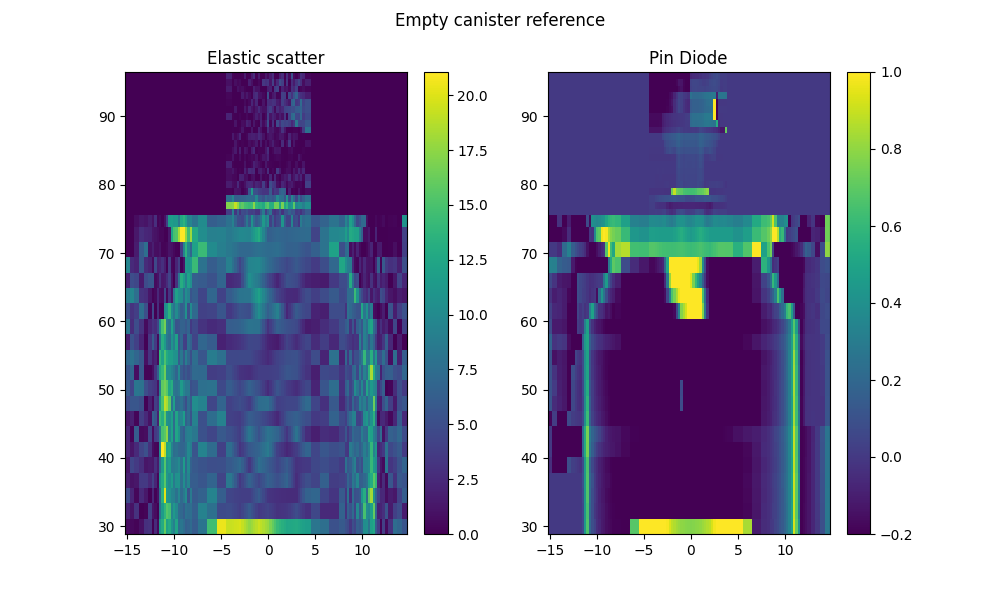

<IPython.core.display.Javascript object>


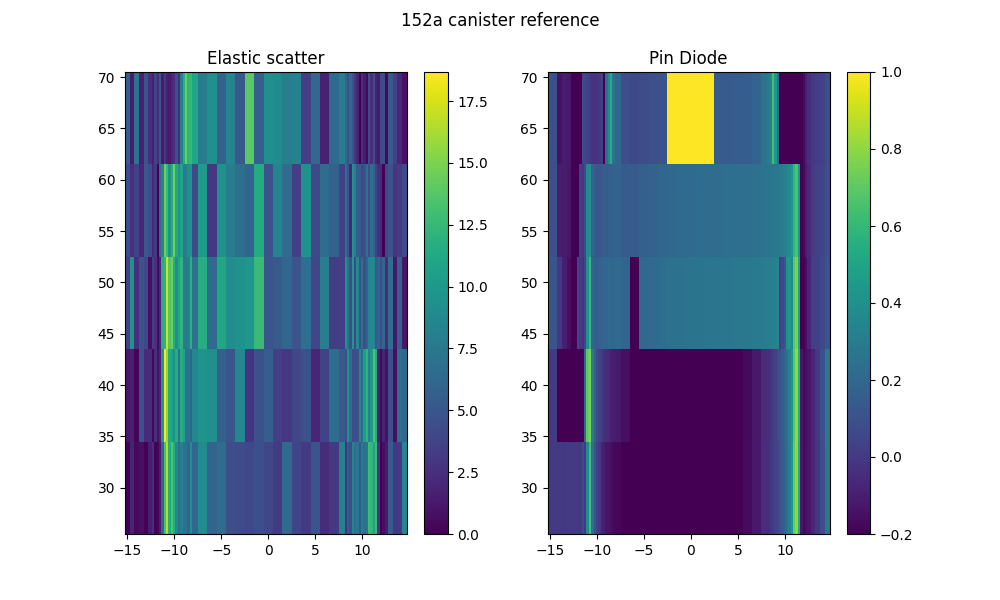

In [749]:
for filename, suptitle in [("KIemptyReference.h5","Empty canister reference"),\
                           ("134 E8 KI Canister 1.h5","152a canister reference")]:
    
    with h5py.File(filename,'r') as H:
        x,y,zE = mergeInterpolateScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/Elastic/integral'] )

        x,y,zP = mergeInterpolateScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/pinDiode'] )

        x,y,I0 = mergeInterpolateScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/diamondMonitor'] )

    # Pin Diode Norm
    zP /= I0
    zP = -np.log(zP)

    # Correct for background level approximately with each horiz. scan.
    for i in range(zP.shape[0]):
        ref=np.nan; xref=12
        while np.isnan(ref):
            if np.any(~np.isnan(zP[i,x[i,...]>xref])):
                ref  = np.nanmean(zP[i,x[i,...]>xref])
                #ref2 = np.nanmean(zE[i,x[i,...]>xref])
            else: 
                ref=np.nan
                #ref2=np.nan
            xref-=0.1
        zP[i,...] -= ref
        zP[i,zP[i,...]<-0.5] -= np.nanmedian(zP[i,zP[i,...]<-0.5])

        #zE[i,...] -= ref2
        #zE[i,zE[i,...]<-0.5] -= np.nanmedian(zE[i,zE[i,...]<-0.5])

    
    # Plot

    fig=plt.figure(figsize=(10,6))
    plt.suptitle(suptitle)
    ax=fig.add_subplot(121)
    ph=ax.pcolormesh(x,y,np.nan_to_num(zE),vmin=0)
    plt.colorbar(ph)
    plt.title("Elastic scatter")

    ax=fig.add_subplot(122)
    ph=ax.pcolormesh(x,y,np.nan_to_num(zP),vmin=-0.2,vmax=1)
    plt.colorbar(ph)
    plt.title("Pin Diode");

## 2. Build functions to calculate the path length through any material to the detector
This determines the magnitude of signal trapping according to Beer's law.

In [35]:
def secant(x,r=1.0):
    ''' 
        Secant of a circle radius r at distance x from the centerline.
        Returns zero when outside the radius.
    '''
    s = np.zeros_like(x)
    s[np.abs(x)<=r] = 2*np.sqrt(r**2 - x[np.abs(x)<=r]**2)
    return s

def secantAnnulus(x,ri,ro):
    '''
        Secant of an annulus with inner radius ri and outer ro, at
        distance x from the centerline.
        Returns zero when outside the radius
    '''
    s = secant(x,ro)
    s -= secant(x,ri)
    return s

### Solve problem for path length from an arbitrary point inside the circle to detector

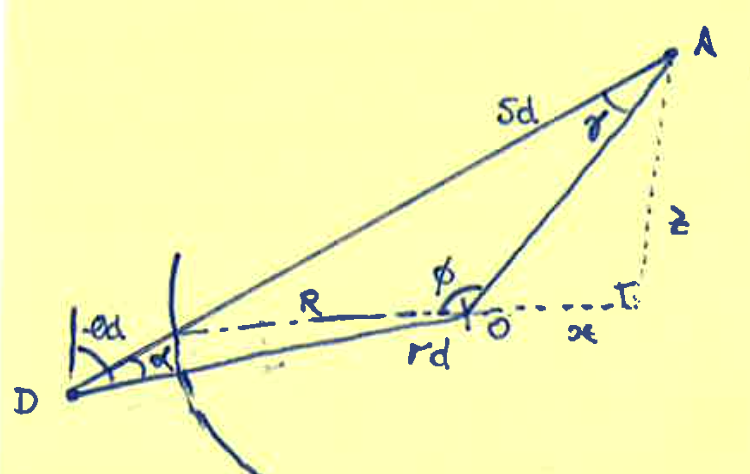

Adding the vertical and horizontal components of OA and OD;

$s_d = \sqrt{\left(r_d \cos \theta_d + z\right)^2 + \left( r_d \sin \theta_d + x \right)^2 }$

Using the cosine rule on triangle OAD; solve for $\gamma$ with

$-2 s_d \sqrt{x^2 + z^2} \cos \gamma =  r_d^2 - x^2 - z^2 - s_d^2 $

Using the cosine rule on triangle OA and point where line AD touches the circle radius R making a length $s_{di}$, and rearranging using the quadratic formula to solve for the unknown length $s_{di}$;

$s_{di} = \frac{-b}{2} \pm \sqrt{\frac{b^2}{4} - c}$

where
$b = 2 \cos \gamma \sqrt{ x^2 + z^2 }$
and
$c = x^2 + z^2 - R^2$

In [740]:
def secantPartialInsideCircle(x,z,R,rDet,thetaDet):
    '''
        Find the length of a segment of a secant from point (x,z) inside a circle of radius R
        to a detector outside the circle at radius rDet and angle thetaDet from the origin.
        
        This function can accept 1D vectors for x and z.
    '''
    rA = np.sqrt(x**2 + z**2)
    
    sd = np.sqrt ( (rDet*np.cos(thetaDet) - x)**2 + (rDet*np.sin(thetaDet) - z)**2 )
    sdQ= np.sqrt ( (rDet*np.cos(thetaDet) + x)**2 + (rDet*np.sin(thetaDet) + z)**2 )    

    cosGamma = (-rDet**2 + x**2 + z**2 + sdQ**2)/(2*sdQ*rA)
    qb = 2*cosGamma*rA
    qc = x**2 + z**2 - R**2

    
    # solve gfsq avoiding imaginary solutions
    de = (qb**2)/4 - qc
    sdi = (-qb/2 + np.sqrt(np.abs(de))) * (de>=0) 
    #sdi2 = (-qb/2 - np.sqrt(np.abs(de))) * (de>=0) 
    
    #sdi = np.nanmax(np.vstack((sdi1,sdi2)),axis=0)
    
    # no negative solutions allowed
    sd[sd<0]=0
    sdi[sdi<0]=0 
    
    # zero solutions outside the circle
    sdi[rA>R]=0
    
    return sd, sdi

def secantRayProjector(x,z,R,rDet,thetaDet,rayResolutionPts=150):
    '''
        For points outside the circle, project a ray and determine the path length of secant that
        passes through the circle. int rayResolutionPts set the number of points along each ray.
        
        This function can accept 1D vectors for x and z.
    '''
    # find ray from point x,z to detector and check if it passes thru the circle
    zDet = rDet*np.sin(thetaDet)
    xDet = rDet*np.cos(thetaDet)
    m = (rDet*np.sin(thetaDet) - z)/(rDet*np.cos(thetaDet) - x)
    c = z - m*x
    xp = np.linspace(x,xDet,rayResolutionPts)
    zp = m*xp + c
    rp = np.sqrt(xp**2 + zp**2)
    rayData = [xp,zp,rp<=R]
    
    sd,sdi = secantPartialInsideCircle(xp,zp,R,rDet,thetaDet)
    
    # set points outside circle with rays passing thru circle to the max value along the ray.
    rA = np.sqrt(x**2 + z**2)
    outsideCircle = rA>R
    sdi_outside = np.zeros_like(x)
    #print(sdi_outside.shape, sdi.shape)
    sdi_outside[outsideCircle] = np.nanmax(sdi[:,outsideCircle],axis=0)
    
    return sdi_outside, rayData
    
def secantPathLengthWrapper(x,z,R,rDet,thetaDet,rayResolutionPts=150):
    ''' 
        A wrapper function to compute the internal and external part of the projected path length
        and add them together. Other returned values are passed through.
        
        This function can accept 1D vectors for x and z.
    '''
    sd,sdi=secantPartialInsideCircle(x,z,R,rDet,thetaDet)
    sdi_outside,rayData=secantRayProjector(x,z,R,rDet,thetaDet,rayResolutionPts)
    return sdi+sdi_outside, sd, rayData

Now test the functions above with a fake cross-section.

<IPython.core.display.Javascript object>


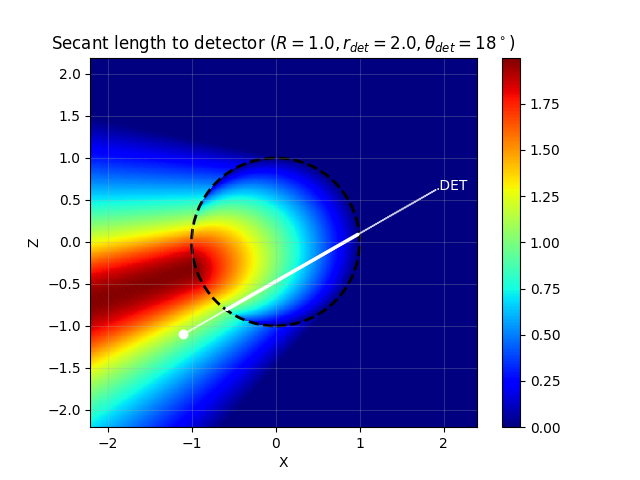

<IPython.core.display.Javascript object>


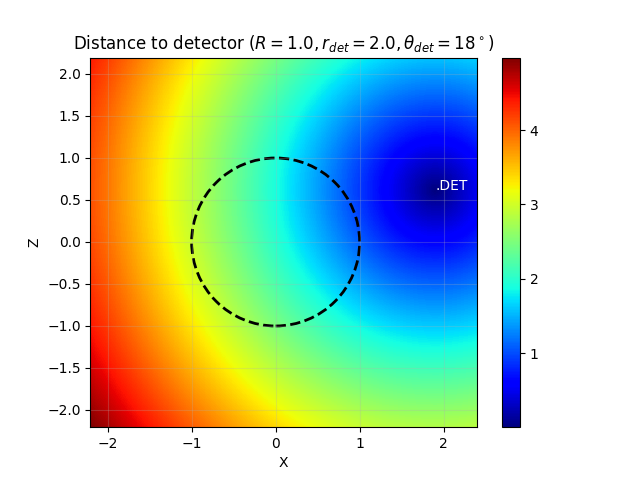

In [741]:
# set geometry
R=1
rDet=2.0
thetaDet=np.pi/10

# Generate detector co-ordinates for plotting purposes
zDet = rDet*np.sin(thetaDet)
xDet = rDet*np.cos(thetaDet)

# Generate vectors to evaluate in 2D
x_ = np.arange(-rDet*1.1,rDet*1.2,.01)
z_ = np.arange(-rDet*1.1,rDet*1.1,.01)

# Generate a 2D grid for plotting
zz,xx = np.meshgrid(z_,x_)

# Loop over z positions, solving a vector of x positions each iteration.
sdi = np.zeros_like(xx)
sd = np.zeros_like(xx)
rays = []
for n in range(len(z_)):
    sdi_, sd_, ray_ = secantPathLengthWrapper(x_,z_[n],R,rDet,thetaDet)
    sdi[:,n] = sdi_+sdi_outside
    sd[:,n] = sd_
    rays.append(ray_)

# Generate surface plots.
fig=plt.figure()
ph=plt.pcolormesh(xx,zz,sdi, cmap=plt.cm.jet)
plt.gca().set_aspect('equal')
plt.grid(alpha=.25)
plt.xlabel("X"); plt.ylabel("Z"); plt.colorbar(ph)
plt.title("Secant length to detector ($R=%.1f, r_{det}=%.1f, \\theta_{det}=%.0f^\circ$)" % (R,rDet,thetaDet*180/np.pi))
circle1 = plt.Circle((0, 0), R, color='k', fill=False, lw=2, ls='--')
plt.gca().add_patch(circle1)
plt.text(xDet,zDet,'.DET',c='w');

# Overlay one sample ray to test that it works.
m=int(len(rays)/4)
plt.scatter(rays[m][0][:,m], rays[m][1][:,m], c='w', s=1+10*rays[m][2][:,m], marker='.')
plt.scatter(x_[m],z_[m],c='w',marker='o')

fig=plt.figure()
ph=plt.pcolormesh(xx,zz,sd, cmap=plt.cm.jet)
plt.gca().set_aspect('equal')
plt.grid(alpha=.25)
plt.xlabel("X"); plt.ylabel("Z"); plt.colorbar(ph)
plt.title("Distance to detector ($R=%.1f, r_{det}=%.1f, \\theta_{det}=%.0f^\circ$)" % (R,rDet,thetaDet*180/np.pi))
circle1 = plt.Circle((0, 0), R, color='k', fill=False, lw=2, ls='--')
plt.gca().add_patch(circle1)
plt.text(xDet,zDet,'.DET',c='w');

## 3. Build functions to predict absorption of incident radiation
We assume that we have a liquid inside the canister that has an unknown fluorescent tracer concentration.

We assume the tracer concentration is low such that it has negligible effect on the transmission; most transmission occurs in the canister/external environment, and in the liquid. 

The measurement we wish to make is to determine the concentration of the tracer.  The fluorescent emission recorded at the detector should be proportional to the amount of absorbed beam in the canister contents along the secant where the beam intersects the liquid, multiplied by the concentration (to solve), multiplied by the transmission of the emission from that concentration through the liquid and walls etc. to the detector.

### 3.1 Canister wall and external environment function
Develop a function to estimate absorption of the incident beam in the external environment, and calibrate this with an empty canister.

In [949]:
canisterWallExtFn_param_names = ['x0','ri','thkCan','muCan', 'thkExtGradient', 'thkExtConst', 'muExt',\
                                 'riValve']

def canisterWallExtFn(x,x0,ri,thkCan,muCan, thkExtGradient, thkExtConst, muExt, riValve):
    '''
        Calculate absorption through canister wall and rectangular external plastic parts of canister holder
        for transverse co-ordinates x with can aligned at center x0, inner radius ri, wall thickness thk.
        
        Assuming by convention all lengths in mm, and mu is attenuation length in _cm_
    '''
    if (ri<0) | (muCan<0) | (thkExtConst<0) | (muExt<0) | (riValve<0): return 0
    if (np.abs(x0)>5) | (np.abs(thkExtGradient)>5) | (np.abs(thkCan)>1.5) | (riValve>4): return 0
    
    return secantAnnulus(x-x0,ri,ri+thkCan)*muCan*0.1 +\
           secant(x-x0,riValve)*muCan*0.1 +\
           (thkExtGradient*(x-x0) + thkExtConst - secantAnnulus(x-x0,ri,ri+thkCan))*muExt*0.1 

Attempt to fit this function to the empty canister data (overfitting may occur)

In [961]:
def calcR2(f, xdata, ydata, popt):
    residuals = ydata- f(xdata, *popt)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    return 1 - (np.nansum(residuals**2) / ss_tot)

<IPython.core.display.Javascript object>


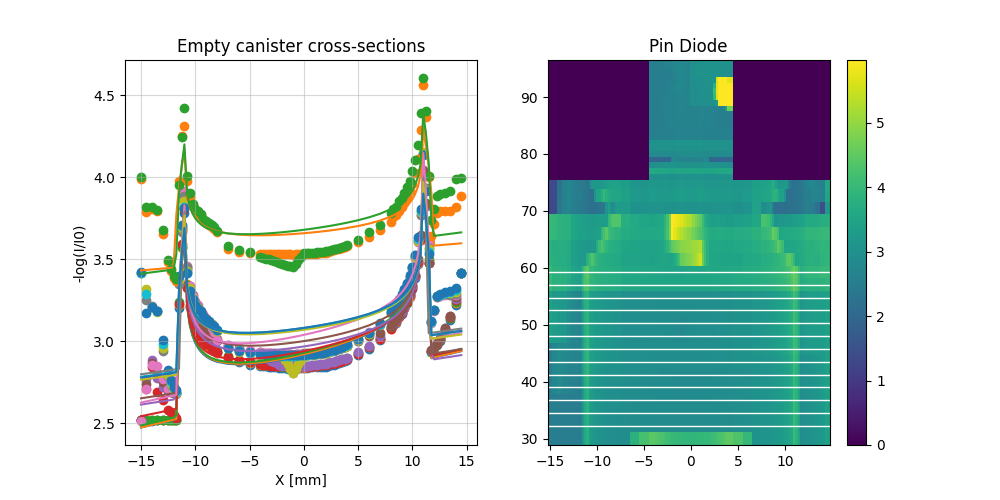

<IPython.core.display.Javascript object>


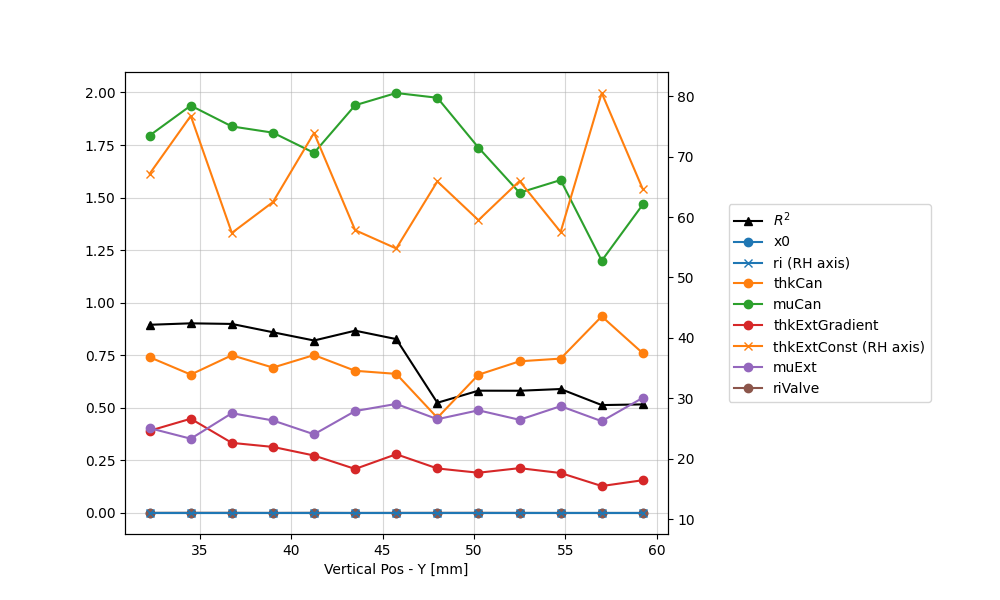

FIT PARAMETERS:
x0=8.9e-07 mm, ri=11.00 mm, thkCan=0.741 mm, muCan=1.795 /cm, thkExt=0.391 x+ 67.172 mm,
	muExt=0.403 /cm, rValve=0.00 mm
x0=-6.9e-05 mm, ri=11.00 mm, thkCan=0.658 mm, muCan=1.938 /cm, thkExt=0.448 x+ 76.755 mm,
	muExt=0.353 /cm, rValve=0.00 mm
x0=-1.3e-05 mm, ri=11.00 mm, thkCan=0.750 mm, muCan=1.839 /cm, thkExt=0.333 x+ 57.377 mm,
	muExt=0.475 /cm, rValve=0.00 mm
x0=3.2e-05 mm, ri=11.00 mm, thkCan=0.692 mm, muCan=1.809 /cm, thkExt=0.314 x+ 62.484 mm,
	muExt=0.440 /cm, rValve=0.00 mm
x0=-8.1e-06 mm, ri=11.00 mm, thkCan=0.751 mm, muCan=1.713 /cm, thkExt=0.273 x+ 73.928 mm,
	muExt=0.374 /cm, rValve=0.00 mm
x0=-9.5e-06 mm, ri=11.00 mm, thkCan=0.676 mm, muCan=1.939 /cm, thkExt=0.209 x+ 57.830 mm,
	muExt=0.485 /cm, rValve=0.00 mm
x0=-5.5e-06 mm, ri=11.00 mm, thkCan=0.662 mm, muCan=1.997 /cm, thkExt=0.279 x+ 54.798 mm,
	muExt=0.519 /cm, rValve=0.00 mm
x0=3e-07 mm, ri=11.00 mm, thkCan=0.453 mm, muCan=1.975 /cm, thkExt=0.212 x+ 65.898 mm,
	muExt=0.446 /cm, rValve=0.00 mm
x0=1.

In [959]:
for filename, suptitle in [("KIemptyReference.h5","Empty canister reference")]:
    
    with h5py.File(filename,'r') as H:
        x,y,zE = mergeInterpolateScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/Elastic/integral'] )

        x,y,zP = mergeInterpolateScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/pinDiode'] )

        x,y,I0 = mergeInterpolateScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/diamondMonitor'] )

    # Pin Diode Norm
    zP /= I0
    zP = -np.log(zP)
    
    # Plot
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(121)
    
    # Attempt to fit background model to each horizontal slice.
    false_result=(np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan)
    initial_guess=(0,11,.65,1.34,.5,10,.1,0)
    fit_popts = []
    r2s = []
    slices = range(1,14) #x.shape[0])
    for m in slices:
        
        flt=(~np.isnan(x[m,:])) & (~np.isnan(zP[m,:]))
        if len(flt)>0:
            #if np.any(~np.isnan(zP[m,np.abs(x[m,:])>11])):
            #    ref = np.nanmin( zP[m,np.abs(x[m,:])>11] )
            #else:
            ref=0
                
            try:
                popt, pcov = scipy.optimize.curve_fit(canisterWallExtFn,x[m,flt],zP[m,flt] - ref,\
                                                      p0=initial_guess)
                r2=calcR2(canisterWallExtFn,x[m,flt],zP[m,flt] - ref,popt)
            except RuntimeError:
                popt=false_result
                r2=np.nan
            
        else:
            popt=false_result
            r2=np.nan
        
        plt.scatter(x[m,:],zP[m,:] - ref,label=None)
        
        # Plot & save if R^2 is high enough.
        if r2>=0.5:
            ym = np.nanmean(y[m,:])
            plt.plot(x[m,:],canisterWallExtFn(x[m,:],*popt),label='$R^2 = %.3f, y=%.1f$ mm' % (r2,ym))
            fit_popts.append(popt)
            r2s.append(r2)
        else:
            fit_popts.append(false_result)
            r2s.append(np.nan)#r2*(r2>0))

    ym=[ np.nanmean(y[m,:]) for m in slices ]
    plt.title("Empty canister cross-sections")
    plt.xlabel("X [mm]")
    plt.ylabel("-log(I/I0)")
    plt.grid(alpha=.5)
    #plt.legend();
    
    # Plot pin diode data for comparison
    ax=fig.add_subplot(122)
    ph=ax.pcolormesh(x,y,np.nan_to_num(zP))
    plt.colorbar(ph)
    plt.title("Pin Diode");
    for y_ in ym: plt.axhline(y_,lw=1,c='w')
    
    # Plot values of fitting variables vs. Y
    fig=plt.figure(figsize=(10,6)); ax=fig.add_subplot(111)
    plt.grid(alpha=.5)
    plt.xlabel("Vertical Pos - Y [mm]")
    all_p=np.array(fit_popts).transpose()
    
    ph,=ax.plot(ym, r2s, label='$R^2$', marker='^',c='k')
    ax2=ax.twinx()
    ll=[ph]
    for p, name in zip(all_p, canisterWallExtFn_param_names):
        if ((name == 'thkExtConst') | (name == 'ri') | (name == 'thkValve')): 
            ph,=ax2.plot(ym, p, label=name+" (RH axis)", marker='x')
        else:
            ph,=ax.plot(ym, p, label=name, marker='o')
        ll.append(ph)

    # Put a legend to the right of the current axis
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
    ax.legend(ll,[l.get_label() for l in ll],loc='center left', bbox_to_anchor=(1.1, 0.5))
    
    print("FIT PARAMETERS:")
    for popt in fit_popts:
        if ~np.isnan(popt[0]):
            print("x0=%.2g mm, ri=%.2f mm, thkCan=%.3f mm, muCan=%.3f /cm, thkExt=%.3f x+ %.3f mm,\n\tmuExt=%.3f /cm, rValve=%.2f mm" % tuple(popt))

    print("\nAVERAGE VALUES OVER Y: (with Std Devs where R^2 > 0.5)")
    for p, name in zip(all_p, canisterWallExtFn_param_names):
        print("%s : %f +- %f" % (name,np.nanmean(p),np.nanstd(p)))

### 3.2 Update function with appropriate constants

From the above we can see that x0~=0, thkCan~=0.71mm, muCan~=1.73/cm, muExt=0.46/cm. These can be assumed to not depend on Y position or canister. 

The values of ri, thkExtGradient, thkExtConst and riValve do depend on Y. However, we can tightly bound them knowing that ri $\leq$ 11mm etc.

Remake the fitting with those values stated above as now fixed.

In [970]:
canisterWallExtFn_param_names = ['ri', 'thkExtGradient', 'thkExtConst','riValve']

def canisterWallExtFn(x, ri, thkExtGradient, thkExtConst, riValve):
    '''
        Calculate absorption through canister wall and rectangular external plastic parts of canister holder
        for transverse co-ordinates x with can aligned at center x0, inner radius ri, wall thickness thk.
        
        Assuming by convention all lengths in mm, and mu is attenuation length in _cm_
    '''
    x0=0
    thkCan=0.706982
    muCan=1.732022
    muExt=0.455318
    
    if (ri<0) | (muCan<0) | (thkExtConst<0) | (muExt<0) | (riValve<0): return 0
    if (ri>12) | (np.abs(thkExtGradient)>1) | (riValve>10): return 0
    
    return secantAnnulus(x-x0,ri,ri+thkCan)*muCan*0.1 +\
           secant(x-x0,riValve)*muCan*0.1 +\
           (thkExtGradient*(x-x0) + thkExtConst - secantAnnulus(x-x0,ri,ri+thkCan))*muExt*0.1 

<IPython.core.display.Javascript object>


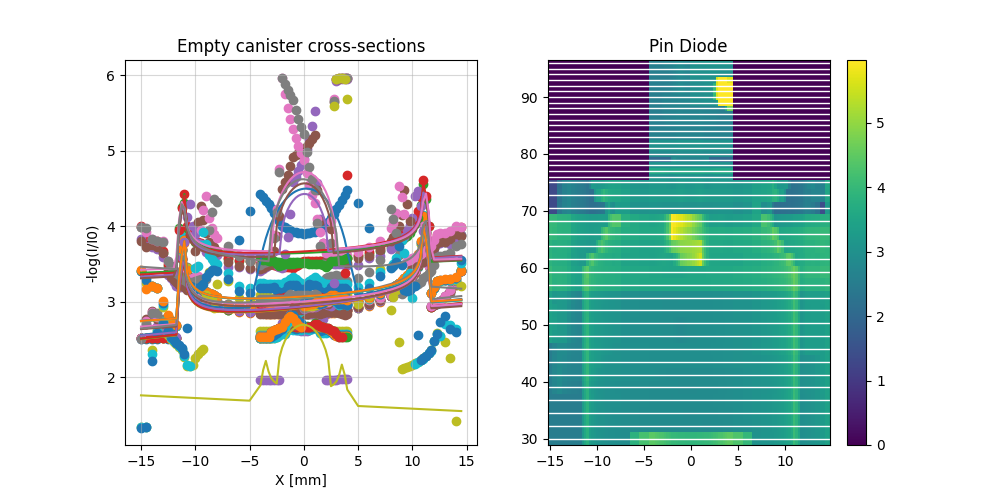

<IPython.core.display.Javascript object>


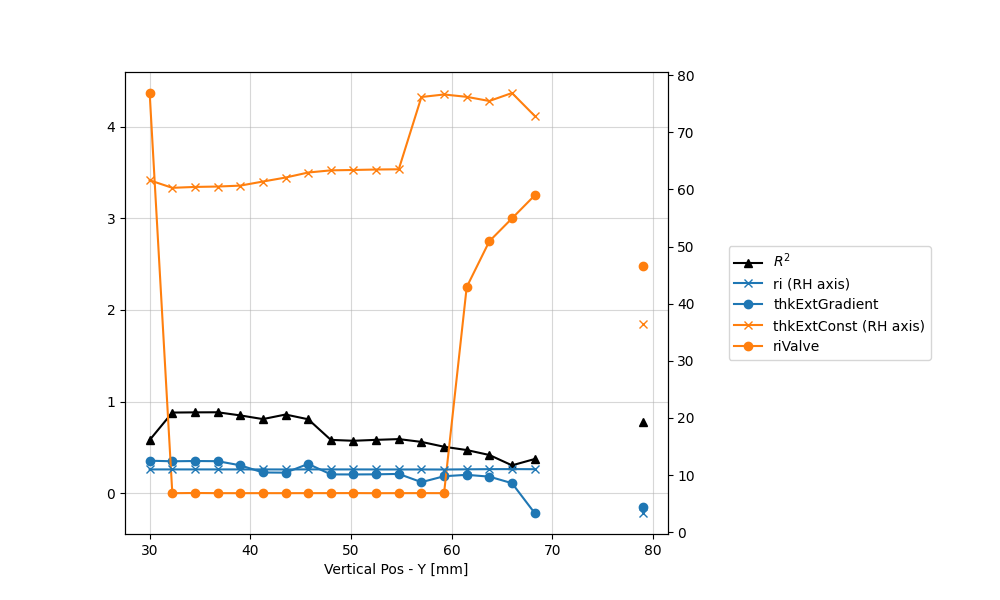

FIT PARAMETERS:
Y=30.00mm :   (R^2 = 0.580)
	ri=11.00 mm, thkExt=0.354 x+ 61.597 mm, rValve=4.37 mm
Y=32.25mm :   (R^2 = 0.880)
	ri=11.00 mm, thkExt=0.348 x+ 60.274 mm, rValve=0.00 mm
Y=34.50mm :   (R^2 = 0.882)
	ri=11.00 mm, thkExt=0.351 x+ 60.430 mm, rValve=0.00 mm
Y=36.75mm :   (R^2 = 0.883)
	ri=11.00 mm, thkExt=0.349 x+ 60.499 mm, rValve=0.00 mm
Y=39.00mm :   (R^2 = 0.849)
	ri=11.00 mm, thkExt=0.304 x+ 60.659 mm, rValve=0.00 mm
Y=41.25mm :   (R^2 = 0.809)
	ri=11.00 mm, thkExt=0.226 x+ 61.374 mm, rValve=0.00 mm
Y=43.50mm :   (R^2 = 0.859)
	ri=10.99 mm, thkExt=0.224 x+ 62.070 mm, rValve=0.00 mm
Y=45.75mm :   (R^2 = 0.807)
	ri=11.01 mm, thkExt=0.320 x+ 62.953 mm, rValve=0.00 mm
Y=48.00mm :   (R^2 = 0.582)
	ri=11.00 mm, thkExt=0.205 x+ 63.330 mm, rValve=0.00 mm
Y=50.25mm :   (R^2 = 0.572)
	ri=11.00 mm, thkExt=0.205 x+ 63.398 mm, rValve=0.00 mm
Y=52.50mm :   (R^2 = 0.582)
	ri=10.99 mm, thkExt=0.206 x+ 63.476 mm, rValve=0.00 mm
Y=54.75mm :   (R^2 = 0.590)
	ri=10.99 mm, thkExt=0.210 x+ 63

In [978]:
for filename, suptitle in [("KIemptyReference.h5","Empty canister reference")]:
    
    with h5py.File(filename,'r') as H:
        x,y,zE = mergeInterpolateScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/Elastic/integral'] )

        x,y,zP = mergeInterpolateScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/pinDiode'] )

        x,y,I0 = mergeInterpolateScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/diamondMonitor'] )

    # Pin Diode Norm
    zP /= I0
    zP = -np.log(zP)
    
    # Plot
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(121)
    
    # Attempt to fit background model to each horizontal slice.
    false_result=(np.nan,np.nan,np.nan,np.nan)
    initial_guess=(11,.5,10,0)
    fit_popts = []
    r2s = []
    slices = range(x.shape[0]) # go for all Y position now
    for m in slices:
        
        flt=(~np.isnan(x[m,:])) & (~np.isnan(zP[m,:]))
        if len(flt)>0:
            #if np.any(~np.isnan(zP[m,np.abs(x[m,:])>11])):
            #    ref = np.nanmin( zP[m,np.abs(x[m,:])>11] )
            #else:
            ref=0
                
            try:
                popt, pcov = scipy.optimize.curve_fit(canisterWallExtFn,x[m,flt],zP[m,flt] - ref,\
                                                      p0=initial_guess)
                r2=calcR2(canisterWallExtFn,x[m,flt],zP[m,flt] - ref,popt)
            except RuntimeError:
                popt=false_result
                r2=np.nan
            
        else:
            popt=false_result
            r2=np.nan
        
        plt.scatter(x[m,:],zP[m,:] - ref,label=None)
        
        # Plot & save if R^2 is high enough.
        if r2>=0.1:
            ym = np.nanmean(y[m,:])
            plt.plot(x[m,:],canisterWallExtFn(x[m,:],*popt),label='$R^2 = %.3f, y=%.1f$ mm' % (r2,ym))
            fit_popts.append(popt)
            r2s.append(r2)
        else:
            fit_popts.append(false_result)
            r2s.append(np.nan)#r2*(r2>0))

    ym=[ np.nanmean(y[m,:]) for m in slices ]
    plt.title("Empty canister cross-sections")
    plt.xlabel("X [mm]")
    plt.ylabel("-log(I/I0)")
    plt.grid(alpha=.5)
    #plt.legend();
    
    # Plot pin diode data for comparison
    ax=fig.add_subplot(122)
    ph=ax.pcolormesh(x,y,np.nan_to_num(zP))
    plt.colorbar(ph)
    plt.title("Pin Diode");
    for y_ in ym: plt.axhline(y_,lw=1,c='w')
    
    # Plot values of fitting variables vs. Y
    fig=plt.figure(figsize=(10,6)); ax=fig.add_subplot(111)
    plt.grid(alpha=.5)
    plt.xlabel("Vertical Pos - Y [mm]")
    all_p=np.array(fit_popts).transpose()
    
    ph,=ax.plot(ym, r2s, label='$R^2$', marker='^',c='k')
    ax2=ax.twinx()
    ll=[ph]
    for p, name in zip(all_p, canisterWallExtFn_param_names):
        if ((name == 'thkExtConst')|(name == 'ri')): 
            ph,=ax2.plot(ym, p, label=name+" (RH axis)", marker='x')
        else:
            ph,=ax.plot(ym, p, label=name, marker='o')
        ll.append(ph)

    # Put a legend to the right of the current axis
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
    ax.legend(ll,[l.get_label() for l in ll],loc='center left', bbox_to_anchor=(1.1, 0.5))
    
    print("FIT PARAMETERS:")
    for popt,y_,r2_ in zip(fit_popts,ym,r2s):
        if ~np.isnan(popt[0]):
            print("Y=%.2fmm :   (R^2 = %.3f)" % (y_,r2_))
            print("\tri=%.2f mm, thkExt=%.3f x+ %.3f mm, rValve=%.2f mm" % tuple(popt))


The above values can be used as approximations for signal trapping in the wall and surrounding plastic. Where there is no good fit, we will have to assume negligible signal trapping here since the PIN signal is weak.